# Analysis of Streamflow Conditions and Historical Streamflows at a Single Gage

This notebook provides a demonstration of the use of [hyswap](https://doi-usgs.github.io/hyswap/) python package for analyzing streamflow conditions at a single streamgage including plotting of flow duration curves, duration hydrographs, and cumulative streamflow. 

This example notebook relies on use of the [dataretrieval](https://github.com/DOI-USGS/dataRetrieval) package for downloading streamflow information from the [USGS Water Data APIs](https://api.waterdata.usgs.gov/).


In [1]:
from dataretrieval import waterdata
from hyswap import exceedance, percentiles, plots, rasterhydrograph, utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore') # ignore warnings from dataretrieval

## Download streamflow data from USGS Water Data for an example site 
For demonstration purposes, retrieving data for gage 04288000 - MAD RIVER AT MORETOWN, VT.

Users can identify streamflow gage locations and site ID numbers through the [USGS National Water Dashboard](https://dashboard.waterdata.usgs.gov/app/nwd/en/)

In [2]:
StaID = 'USGS-04288000'
flow_data,_ = waterdata.get_daily(
    monitoring_location_id=StaID,
    parameter_code='00060',
    time='1900-01-01/..',
    properties=[
        'monitoring_location_id',
        'parameter_code',
        'time',
        'value',
        'unit_of_measure',
        'approval_status'])

station_name,_ = waterdata.get_monitoring_locations(
    monitoring_location_id=StaID)
station_name = station_name.loc[0, 'monitoring_location_name']

In [3]:
if 'value' in flow_data.columns:
    # set preliminary, non-valid observations (-999999) to NaN
    flow_data['value'] = flow_data['value'].replace(-999999, np.nan)

    # create a filtered version of data of only USGS approved data (quality-assured data that may be published and used in statistical analsysis)
    approved_flow_data = utils.filter_approved_data(flow_data, 'approval_status')
else:
    print('No standard discharge data column found for site ' + StaID + ', suggest using a different site')

In [4]:
# view a sample of data records
flow_data.head()

,monitoring_location_id,parameter_code,time,value,unit_of_measure,approval_status,geometry
0,USGS-04288000,00060,1928-10-01,70.0,ft^3/s,Approved,POINT (-72.74262 44.27728)
1,USGS-04288000,00060,1928-10-02,70.0,ft^3/s,Approved,POINT (-72.74262 44.27728)
2,USGS-04288000,00060,1928-10-03,70.0,ft^3/s,Approved,POINT (-72.74262 44.27728)
3,USGS-04288000,00060,1928-10-04,70.0,ft^3/s,Approved,POINT (-72.74262 44.27728)
4,USGS-04288000,00060,1928-10-05,65.0,ft^3/s,Approved,POINT (-72.74262 44.27728)


## Perform simple data check and exploration by plotting hydrographs of select water years

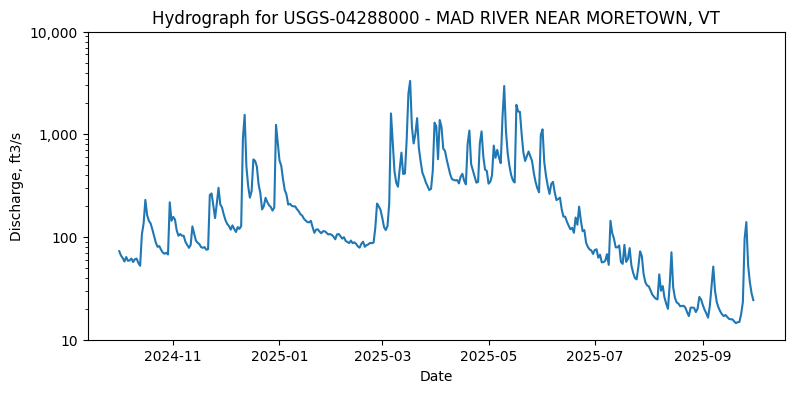

In [5]:
#| fig-cap: Sample HySwap hydrograph plot
plot_start = "2024-10-01"
plot_end = "2025-09-30"

fig, ax = plt.subplots(figsize=(9,4))
ax = plots.plot_hydrograph(flow_data,
                           data_column_name = "value",
                           date_column_name="time",
                           start_date = plot_start,
                           end_date = plot_end,
                           title = f"Hydrograph for {StaID} - {station_name}",
                           ax = ax)
plt.show()

Next, try changing the plot to not have log scale on the y-axis

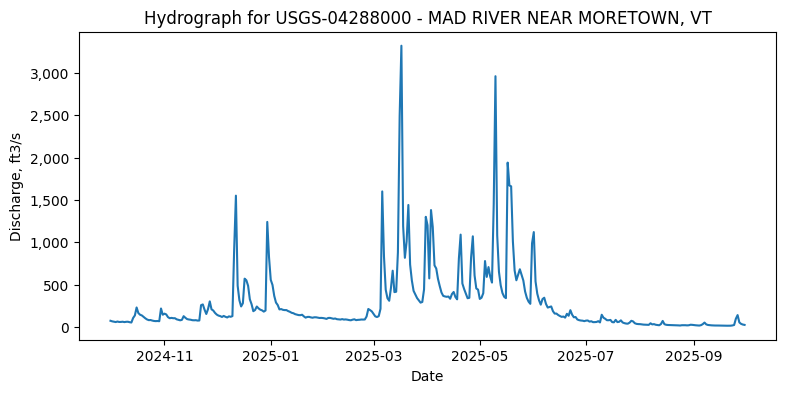

In [6]:
#| fig-cap: Sample HySwap hydrograph plot
fig, ax = plt.subplots(figsize=(9,4))
plots.plot_hydrograph(flow_data, 
                       data_column_name = "value",
                       date_column_name="time", 
                       start_date=plot_start,
                       end_date=plot_end,
                       title=f"Hydrograph for {StaID} - {station_name}",
                       yscale = 'linear',
                       ax = ax)
plt.show()

Now test doing some plot customizations including axis labels, colors, plot style

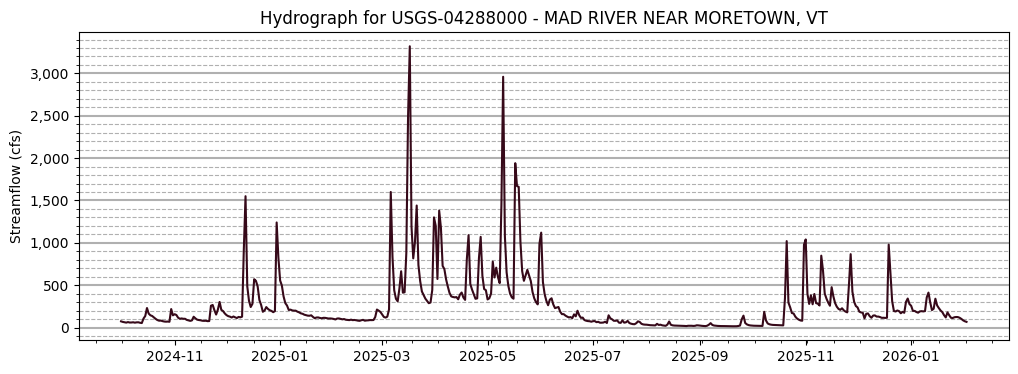

In [7]:
#| fig-cap: Sample HySwap hydrograph plot with customized appearance
plot_start = "2024-10-01"
fig, ax = plt.subplots(figsize=(12,4))
ax = plots.plot_hydrograph(flow_data, 
                       data_column_name = "value",
                       date_column_name="time",
                       start_date=plot_start,
                       title=f"Hydrograph for {StaID} - {station_name}",
                       yscale = 'linear',
                       ylab = 'Streamflow (cfs)',
                       xlab = '',
                       color = '#360919',
                       ax = ax)
ax.grid(which = "major", axis="y", lw = 1.5)
ax.grid(which = "minor", axis="y", linestyle = "dashed")
ax.minorticks_on()
plt.show()

## Analyze the long-term record of streamflow
Review summary statistics and flow records using raster hydrographs

In [8]:
# calculate summary statistics on only approved data (quality-assured data that may be published and used in statistical analsysis)
summary_stats = utils.calculate_summary_statistics(
    df=approved_flow_data,
    data_column_name='value',
    date_column_name='time'
    )

In [9]:
#| tbl-cap: Example table of summary statistics
summary_stats

,Summary Statistics
Site number,USGS-04288000
Begin date,1928-10-01
End date,2025-07-30
Count,35367
Minimum,2.9
Mean,275.58
Median,150.0
Maximum,6840.0


To view long-term patterns and trends in streamflow, raster hydrographs can be plotted using `hyswap`.
Here, let's utilize a raster hydrograph to see the historical flow at the site from the past 50 years (1973-2023)

In [10]:
# format the data
df_formatted = rasterhydrograph.format_data(
    df=flow_data,
    data_column_name='value',
    date_column_name='time',
    year_type="calendar",
    begin_year=1973,
    end_year=2023
    )

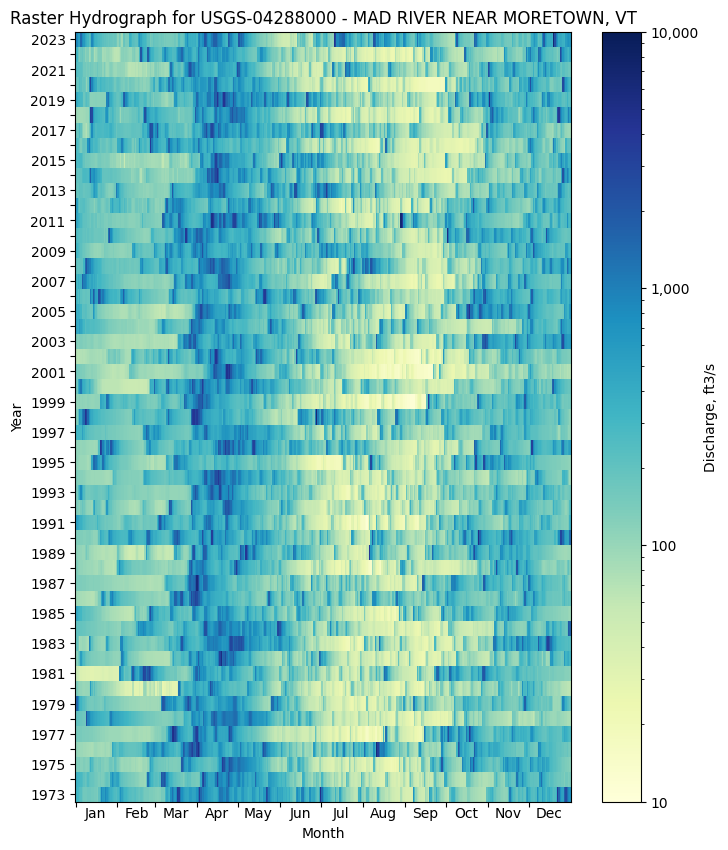

In [11]:
#| fig-cap: Sample raster hydrograph showing past 50 years of streamflow
# make plot
fig, ax = plt.subplots(figsize=(8,10))
ax = plots.plot_raster_hydrograph(
    df_formatted=df_formatted, 
    ax=ax,
    title=f"Raster Hydrograph for {StaID} - {station_name}")
plt.show()

Next, try customizing the raster hydrograph by changing to water years, using a different colormap, removing the leap day, and showing all years that have data.

In [12]:
# re-format data
df_formatted = rasterhydrograph.format_data(
    df=flow_data,
    data_column_name='value',
    date_column_name='time',
    year_type="water", 
    clip_leap_day=True
    )

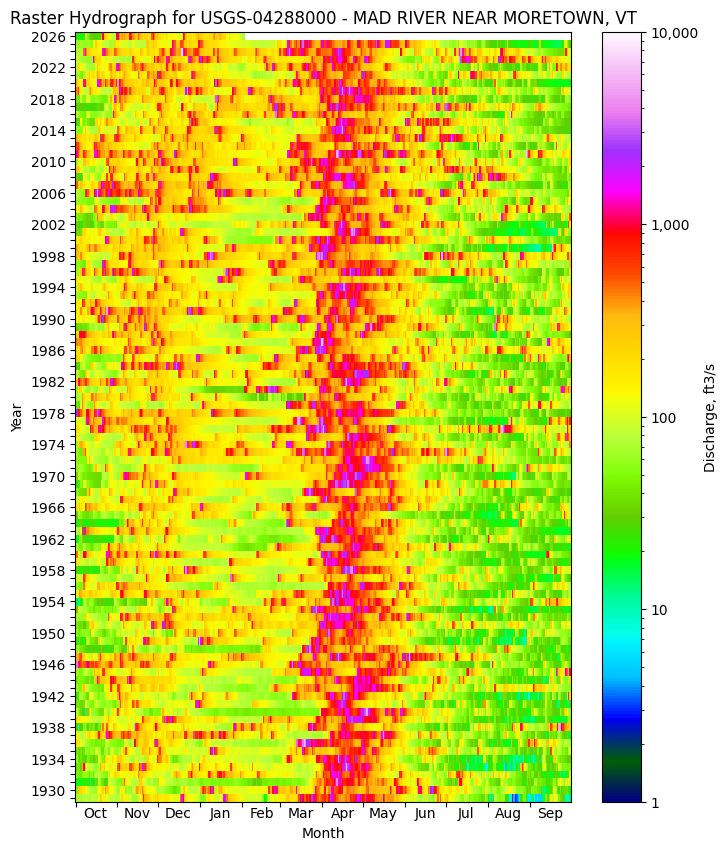

In [13]:
#| fig-cap: Sample raster hydrograph showing all daily streamflow records from a site
# make plot
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot()
ax = plots.plot_raster_hydrograph(
    df_formatted=df_formatted, 
    ax=ax,
    title=f"Raster Hydrograph for {StaID} - {station_name}",
    cmap='gist_ncar')
plt.show()

## Analyze annual streamflow through cumulative flow and flow duration curves 
Use calculations of streamflow percentiles (variable by day) to analyze annual patterns in streamflow

Let's look at the last four years (2020-2023) of cumulative streamflow by plotting cumulative hydrographs of different water years along with the envelope that 90% of annual cumulative streamflow is expected to be within, and the years with the minimum and maximum annual cumulative streamflows.

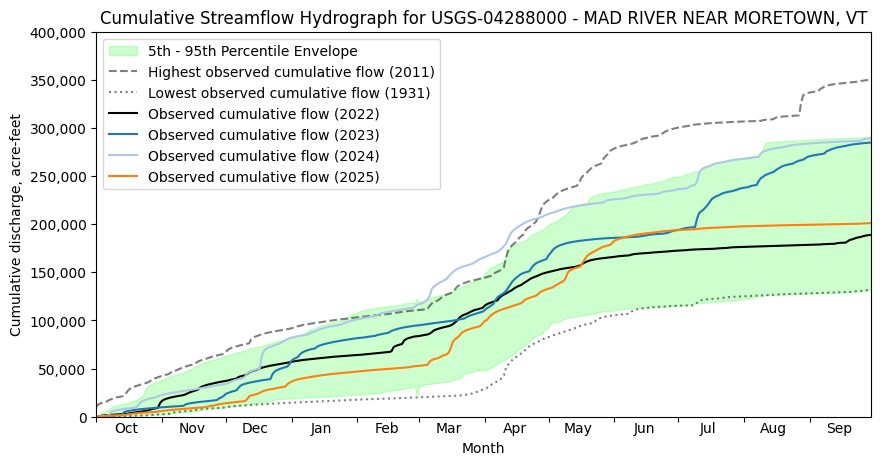

In [14]:
#| fig-cap: Sample cumulative hydrograph showing multiple water years of cumulative streamflow
years_to_plot = [2022, 2023, 2024, 2025]
# plot the cumulative streamflow hydrograph
fig, ax = plt.subplots(figsize=(10, 5))
ax = plots.plot_cumulative_hydrograph(
    df=flow_data,
    data_column_name='value',
    date_column_name='time',
    target_years=years_to_plot,
    ax=ax, 
    title=f'Cumulative Streamflow Hydrograph for {StaID} - {station_name}',
    envelope_pct = [5,95],
    max_year=True, 
    min_year=True,
    year_type = 'water',
    alpha=0.2)
plt.show()

Next, look at the flow duration curve for a site

In [15]:
# create data for flow duration curve
# generate 1,000 evenly spaced values between the min and max flow to create a smooth line
values = np.linspace(flow_data['value'].min(), flow_data['value'].max(), 1000)
# calculate exceedance probabilities from the daily mean streamflow values using only approved data
exceedance_probabilities = exceedance.calculate_exceedance_probability_from_values_multiple(
    values, approved_flow_data['value'])

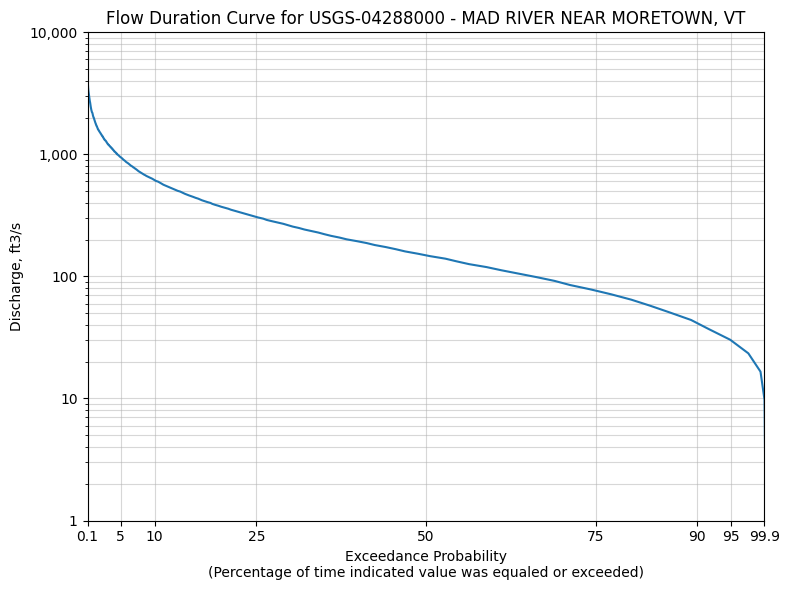

In [16]:
#| fig-cap: Example flow duration curve for a single gage
# plot the flow duration curve
fig, ax = plt.subplots(figsize=(8, 6))
ax = plots.plot_flow_duration_curve(
    values=values, 
    exceedance_probabilities=exceedance_probabilities, 
    ax=ax,
    title=f'Flow Duration Curve for {StaID} - {station_name}')
# show the plot
plt.tight_layout()
plt.show()

Next, look at the seasonality and variability of streamflow at a single site by plotting a streamflow duration hydrograph.

In [17]:
# create data for streamflow duration hydrograph from approved flow data
percentiles_by_day = percentiles.calculate_variable_percentile_thresholds_by_day(
    df=approved_flow_data,
    data_column_name="value",
    date_column_name="time"
    )

In [18]:
#| tbl-cap: Calculated streamflow percentile thresholds for a streamgage
# View a sample of this data
display(percentiles_by_day.head())

,min,p05,p10,p25,p50,p75,p90,p95,max,mean,count,start_yr,end_yr
month_day,,,,,,,,,,,,,
01-01,42.0,55.9,70.0,108.0,155.0,292.5,461.8,804.4,1780.0,249.55,97,1929,2025
01-02,45.0,53.8,70.0,105.0,153.0,297.5,498.0,692.9,1500.0,238.15,97,1929,2025
01-03,45.0,53.7,77.4,110.0,160.0,278.0,424.0,522.4,800.0,214.72,97,1929,2025
01-04,40.0,56.0,77.8,102.5,170.0,289.0,393.6,536.0,680.0,207.44,97,1929,2025
01-05,36.0,58.8,75.6,104.0,155.0,254.5,360.0,500.3,1470.0,212.14,97,1929,2025


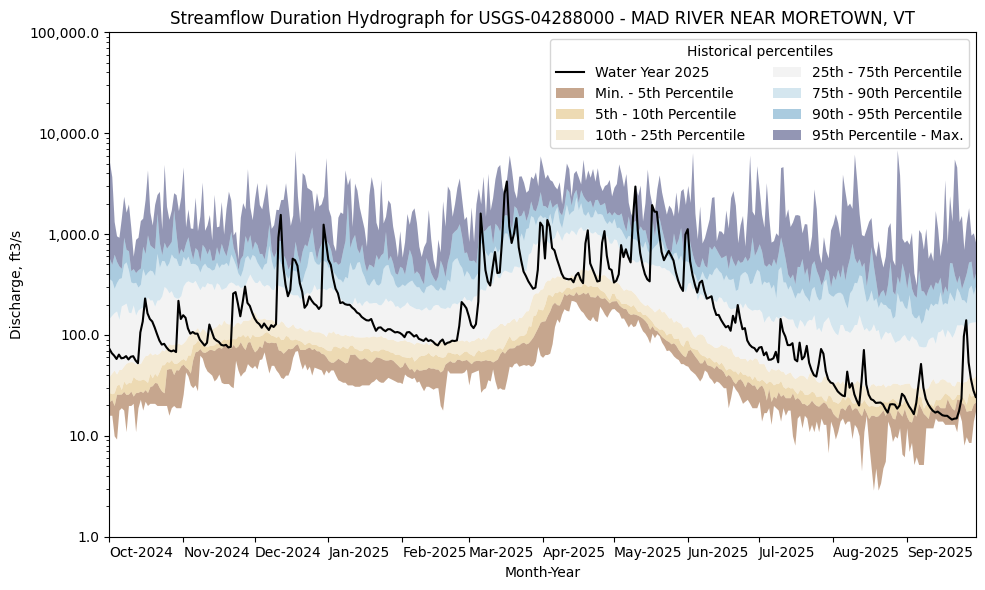

In [19]:
#| fig-cap: Example Streamflow Duration Hydrograph for a Streamgage
# plotting percentiles by day with line shade between
fig, ax = plt.subplots(figsize=(10, 6))
water_year_to_plot = 2025
# get year/doy information
df_indexed = utils.define_year_doy_columns(
    df_in=flow_data,
    date_column_name='time',
    year_type='water',
    clip_leap_day=True
    )
# filter down to data from selected year
df_year = df_indexed[df_indexed['index_year'] == water_year_to_plot].copy()
# plot data
ax = plots.plot_duration_hydrograph(
    percentiles_by_day=percentiles_by_day,
    df=df_year,
    data_column_name="value",
    ax=ax,
    data_label=f"Water Year {water_year_to_plot}",
    title=f"Streamflow Duration Hydrograph for {StaID} - {station_name}"
)
plt.tight_layout()
plt.show()